# Introduction

As we've learned, deep neural networks provide (at least partly) hierarchical representations of data, tailored for a given task. 

At the end of a high-performance deep neural network, i.e. in the later hidden layers, you'll find a representation for each data instance that makes the task (relatively) easy to solve. 

An idea that can be quite useful in a wide variety of tasks is to _extract_ these representations and use them in other ML models. This is one easy way to combine information extracted by a deep neural network with other useful information for the task at hand. 

We'll use this idea in this notebook by extracting vector representations from the last hidden layer of a trained CNN, and use them to for training other ML models.

# Setup

In [ ]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, as that makes some difference for the code below.
# We'll do this in every notebook of the course.
if 'google.colab' in str(get_ipython()):
    print('The notebook is running on Colab. colab=True.')
    colab=True
else:
    print('The notebook is not running on Colab. colab=False.')
    colab=False

In [ ]:
gradient=False

In [ ]:
%matplotlib inline
import pandas as pd, numpy as np
from pathlib import Path
import sys
sys.path.append('../')

In [ ]:
NB_DIR = Path.cwd()

DATA = NB_DIR/'dev-notebooks'/'data'/'drug'
RAWDATA = DATA/'raw'
LOCALDATA = DATA/'interim'

if gradient:
    IMGDATA = Path('/storage/molimages')
else:
    # Path to image data as defined earlier
    IMGDATA = Path('/data2/alex/pcs-data/drug/molimages')

In [ ]:
from fastai.vision.all import *

# Load data

In [ ]:
def get_df(data):
    """
    Construct a dataframe containing 
        CID, SMILES, Image, Activity
    """
    
    name = "_".join(str(data.stem).split("_")[:2])
    
    df = pd.read_csv(data)
    df['Image'] = df['CID'].apply(lambda x: f'{str(x)}.png')
    
    return df[['CID', 'SMILES', 'Image', 'Activity']], name

We remember that we had 7 activity datasets:

In [ ]:
# Datasets available:
data = sorted(list(LOCALDATA.ls(file_exts='.csv')))
data

...and that we've generated images of the molecules:

In [ ]:
IMGDATA.ls()

We'll use the **CHEMBL1978** data set in this notebook, as it's one of the smaller ones (and therefore quicker to train models on and to extract features from):

In [ ]:
ds = data[0]
ds

In [ ]:
df, name = get_df(ds)

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df['Activity'].value_counts()

## Create train-val-split and oversample train

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def val_cols_and_oversample(df, test_size=0.25, random_state=42, oversample=True):
    x_train,x_val = train_test_split(df.index, test_size=test_size, stratify=df['Activity'], 
                                     random_state=random_state)
    
    df.loc[x_train, 'is_valid']=False
    df.loc[x_val, 'is_valid']=True
    # Oversample is_valid=False columns
    if oversample:
        df = pd.concat([*[df.loc[(df.is_valid==False) & (df.Activity==1)]]*10, 
                        *[df.loc[(df.is_valid==False) & (df.Activity==0)]], 
                        df.loc[df.is_valid==True]], 
                       ignore_index=True)
    return df

In [ ]:
df = val_cols_and_oversample(df)

In [ ]:
df.head()

In [ ]:
df['Activity'].value_counts()

# Create a dataloader

In [ ]:
bs=64

In [ ]:
batch_tfms = [Rotate(max_deg=25, pad_mode='border'), 
              Normalize.from_stats(*imagenet_stats)]

In [ ]:
IMGDATA

In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=ColSplitter('is_valid'),
    item_tfms=None,
    batch_tfms=batch_tfms
    )

In [ ]:
dls = datablock.dataloaders(df, bs=bs, shuffle_train=True)

In [ ]:
dls.show_batch()

# Train a CNN

In [ ]:
# Copied from here: https://forums.fast.ai/t/plotting-metrics-after-learning/69937/3
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, endnames=-1, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:endnames]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()
    

We use a pretrained resnet18 model as before, only adding a custom "head" to the model that outputs 128 features (to have fewer activations in the final hidden layer):

In [ ]:
custom_head = create_head(nf=512, n_out=2, lin_ftrs=[128], concat_pool=True)

In [ ]:
custom_head

In [ ]:
learn = cnn_learner(dls,                             
                arch=resnet18, pretrained=True,  
                custom_head=custom_head,
                wd=2e-4, ps=0.8,                    
                metrics=[accuracy,                  
                         F1Score(), 
                         Precision(), 
                         Recall(), 
                         RocAucBinary(), 
                         MatthewsCorrCoef()],
                cbs=[ShowGraphCallback()])

The below training takes a while. We can rather load the results of a previous run:

In [ ]:
#learn = learn.load('chembl1978-model-test-hooks')

/home/ubuntu/anaconda3/envs/pcs956/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


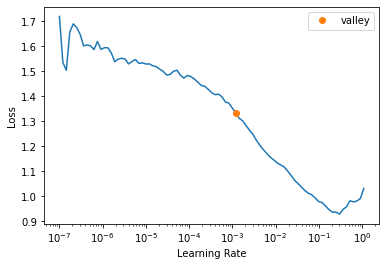

In [36]:
lr = learn.lr_find()

In [37]:
lr

SuggestedLRs(valley=0.0012022644514217973)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.283956,0.203760,0.919789,0.680653,0.532847,0.941935,0.977791,0.672752,00:35


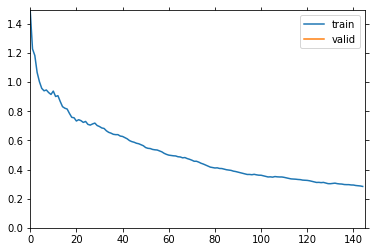

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,roc_auc_score,matthews_corrcoef,time
0,0.158995,0.160242,0.947892,0.767624,0.644737,0.948387,0.981952,0.756960,00:43
1,0.125174,0.121150,0.973653,0.863222,0.816092,0.916129,0.978684,0.850436,00:43
2,0.083101,0.103432,0.972482,0.844884,0.864865,0.825806,0.979125,0.830062,00:43
3,0.068864,0.081410,0.978923,0.881579,0.899329,0.864516,0.981767,0.870220,00:43
4,0.046909,0.096359,0.974824,0.870871,0.814607,0.935484,0.982029,0.859515,00:43
5,0.029127,0.092431,0.978923,0.883117,0.888889,0.877419,0.979856,0.871557,00:43
6,0.020186,0.091378,0.981265,0.898089,0.886792,0.909677,0.979050,0.887862,00:43
7,0.012010,0.089089,0.982436,0.903846,0.898089,0.909677,0.980793,0.894204,00:43


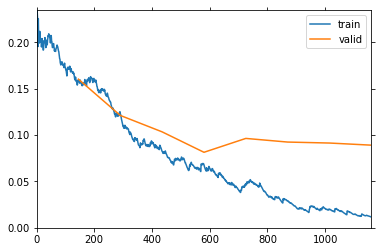

In [38]:
learn.freeze()
learn.fit(1, lr.valley)
learn.unfreeze()
learn.fit_one_cycle(8, slice(lr.valley))

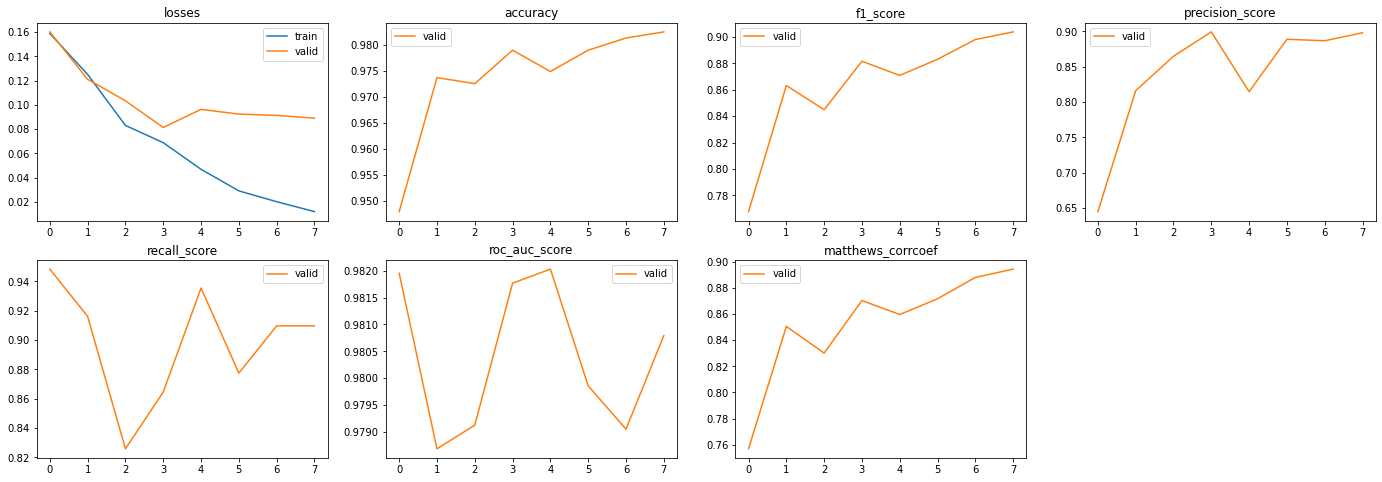

In [39]:
learn.recorder.plot_metrics()

In [ ]:
learn.save('chembl1978-model-test-hooks')

### Evaluate

In [40]:
interp = ClassificationInterpretation.from_learner(learn)

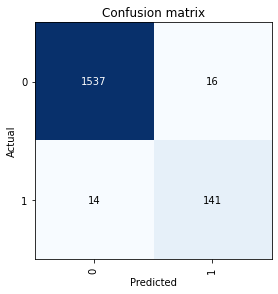

In [41]:
interp.plot_confusion_matrix()

# Save activations 

from second final layer. To be used to train a different ML model.

We need to register a "hook" at the layer we want to save activations from:

In [ ]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [ ]:
learn.model[-1][-5]

In [ ]:
hook_output = Hook()
hook = learn.model[-1][-5].register_forward_hook(hook_output.hook_func)

Create the df again, this time with no oversampling (as that's not necessary).

In [ ]:
df, name = get_df(ds)

df_nodupl = val_cols_and_oversample(df, oversample=False)

No data augmentation:

In [ ]:
test_db = DataBlock(
    blocks=(ImageBlock(), CategoryBlock()),
    get_x=ColReader('Image', pref=IMGDATA/name),
    get_y=ColReader('Activity'),
    splitter=RandomSplitter(valid_pct=0.),
    item_tfms=None,
    batch_tfms=None
    )

We can feed one image at a time throught the model to get the activations

In [ ]:
test_dls = test_db.dataloaders(df_nodupl, bs=1)

In [ ]:
test_df = test_dls.items.reset_index()

In [ ]:
test_df.head()

Each element of the dataset consists of an image (a `PILImage`) and a category (the corresponding activity label):

In [ ]:
test_dls.dataset[0]

In [ ]:
test_dls.dataset[0][0]

In [ ]:
def get_data(CID):
    idx = test_df.loc[test_df.CID==CID].index[0]
    print(idx)
    return test_dls.dataset[idx]

In [ ]:
def get_activations(CID):
    idx = df_nodupl.loc[df_nodupl.CID == CID].index[0]
    data = get_data(CID)
    img = data[0]
    
    with torch.no_grad(): 
        output = learn.predict(img)
    acts = np.array(hook_output.stored.cpu())[0]

    return list(acts)

The below computation takes a while.. We can rather load results computed earlier:

In [ ]:
df_acts = pd.read_csv('data/chembl1978_cnn_activations.csv')
df_acts.head()

In [ ]:
#%%time
#%%capture
#df_nodupl['activations'] = df_nodupl.CID.apply(get_activations)

Now we've stored activations for each image:

In [ ]:
#df_nodupl.head()

We split the activations to have one column for each, as they will be treated as separate features later:

In [ ]:
#df_acts = pd.concat([df_nodupl, pd.DataFrame(df_nodupl.activations.values.tolist()).add_prefix('act_')], axis=1)

In [ ]:
#df_acts.drop('activations', axis=1, inplace=True)

Here's the result:

In [ ]:
#df_acts.head()

In [ ]:
#df_acts.info()

In [ ]:
#df_acts.to_csv('data/chembl1978_cnn_activations.csv', index=None)

# Add molecular fingerprints

When training the random forest below, we'll compare the results obtained by using _molecular fingerprints_ as features describing molecules. See the notebook `dev-noteboos/DL-Example-3-get_molecular_fingerprints_and_images.ipynb` for the code to generate fingerprints.

In [ ]:
df_ecfp = pd.read_csv(LOCALDATA/'CHEMBL1978_cl_ecfp_1024.csv')

In [ ]:
df_ecfp.head()

In [ ]:
df_ecfp.info()

In [ ]:
df_acts.info()

In [ ]:
df = df_ecfp.merge(df_acts, on='CID')

In [ ]:
df.head()

In [ ]:
df.drop(['SMILES_y', "Activity_y"], axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
df.rename(columns={'SMILES_x': 'SMILES', 'Activity_x': 'Activity'}, inplace=True)

Save the dataframe:

In [ ]:
LOCALDATA

In [ ]:
df.to_csv('data/chembl1978-data-with-ecfp-activations.csv', index=None)

# Train machine learning models on extracted features

### Split the data

We use the validation data from the CNN model as test data (as it's unseen by the CNN model during training).

In [ ]:
train = df.loc[df.is_valid==False]
test = df.loc[df.is_valid==True]

In [ ]:
X_train, y_train = train.drop(["CID", "SMILES", "Activity", "Image"], axis=1), train["Activity"]

In [ ]:
X_test, y_test = test.drop(["CID", "SMILES", "Activity", "Image"], axis=1), test["Activity"]

In [ ]:
X_train.head()

In [ ]:
y_train.head()

### A logistic regression model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [ ]:
from sklearn.metrics import (roc_auc_score, accuracy_score, recall_score, 
matthews_corrcoef, precision_score, f1_score)

In [ ]:
def train_lr(X_train, X_test, y_train, y_test, features='ECFP'):
    
    if features!='all':
        X_train = X_train[[c for c in X_train.columns if features in c]]
        X_test = X_test[[c for c in X_test.columns if features in c]]
        print(f'Training on {len(X_train.columns)} features\n')
    else:
        print(f'Training on all {len(X_train.columns)} ECFP and CNN features\n')
    
    # Must scale the data for the linear logreg model:
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.transform(X_test)
    
    
    lr = LogisticRegression(max_iter=500)
  
    lr.fit(X_train_std, y_train)
    
    y_pred = lr.predict(X_test_std)
    y_pred_prob = lr.predict_proba(X_test_std)
    
    temp=[]
    for j in range(len(y_pred_prob)):
    	temp.append(y_pred_prob[j][1])
    auc=roc_auc_score(np.array(y_test),np.array(temp))
    acc2=accuracy_score(y_test,y_pred)
    mcc=matthews_corrcoef(y_test,y_pred)
    Recall=recall_score(y_test, y_pred,pos_label=1)
    Precision=precision_score(y_test, y_pred,pos_label=1)
    F1_score=f1_score(y_test, y_pred,pos_label=1)
    
    print(f'AUC: {auc}')
    print(f'Accuracy: {acc2}')
    print(f'MCC: {mcc}')
    print(f'Recall: {Recall}')
    print(f'Precision: {Precision}')
    print(f'F1_score: {F1_score}')

    return auc,acc2,mcc,Recall,Precision,F1_score, lr

In [ ]:
_ = train_lr(X_train, X_test, y_train, y_test, features='ECFP')

In [ ]:
_ = train_lr(X_train, X_test, y_train, y_test, features='act_')

In [ ]:
_ = train_lr(X_train, X_test, y_train, y_test, features='all')